# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
#This code imports various libraries and classes necessary for data analysis and machine learning using Apache Spark.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, count, desc, explode, lit, min, max, split, stddev, udf
from pyspark.sql.types import IntegerType, StringType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier

In [2]:
# Retrieves an existing SparkSession or creates a new one if it doesn't exist. This ensures that only one SparkSession is active per JVM (Java Virtual Machine).
spark = SparkSession.builder \
    .appName("Capstone Project") \
    .getOrCreate()

# Reads the JSON data from the specified file into a DataFrame.
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.format("json").load(sparkify_data)

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#It is used to show the structure of the DataFrame in the form of a tree
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
#used to convert the Apache Spark df DataFrame to a Pandas DataFrame
df1 = df.toPandas()
df1.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [5]:
#used to get information about the DataFrame
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


In [6]:
#This code extracts the unique values ​​from various columns of the df1 DataFrame and displays them to the console, allowing us to better understand the different values ​​that appear in those columns and gain insight into the diversity of data in those categories.
unique_levels = df1['level'].unique()
unique_methods = df1['method'].unique()
unique_pages = df1['page'].unique()
unique_statuses = df1['status'].unique()
unique_genders = df1['gender'].unique()
unique_auths = df1['auth'].unique()

print(unique_levels, unique_methods, unique_pages, unique_statuses, unique_genders, unique_auths)

['paid' 'free'] ['PUT' 'GET'] ['NextSong' 'Add to Playlist' 'Roll Advert' 'Thumbs Up' 'Downgrade'
 'Thumbs Down' 'Home' 'Logout' 'Help' 'Login' 'Upgrade' 'Add Friend'
 'About' 'Settings' 'Submit Upgrade' 'Submit Downgrade' 'Error'
 'Save Settings' 'Cancel' 'Cancellation Confirmation' 'Register'
 'Submit Registration'] [200 307 404] ['M' 'F' None] ['Logged In' 'Logged Out' 'Cancelled' 'Guest']


In [7]:
#this code counts the number of records in the df1 DataFrame that have an empty value in the 'userId' column and displays that count to the console. This allows us to identify how many records in the dataset do not have a 'userId' assigned to them and gives us information about the integrity of the data in that column.
empty_user_ids_count = df1.loc[df1['userId'] == '', 'userId'].count()
print(empty_user_ids_count)

8346


In [8]:
#the code counts the number of records in the DataFrame df that have an empty string as value in the 'sessionId' column. This allows us to identify how many records have an empty 'sessionId' in the dataset and gives us information about the integrity of the data in that column.
df.filter(df.sessionId == '').count()

0

In [9]:
#the code first filters the DataFrame df to remove rows that have an empty 'userId' and then counts the number of records that still have an empty 'userId'. This allows us to check how many records have been deleted and gives us information about the integrity of the data in the 'userId' column.
df = df.filter(df.userId != '')
df.filter(df.userId == '').count()

0

In [10]:
#converts the Spark DataFrame df to a Pandas DataFrame called df1
df1 = df.toPandas()

In [11]:
#seeks to get the unique values ​​of various columns of the dfp DataFrame and store them in separate variables. Unique values ​​are obtained using the set() function, which removes duplicates, and then converted to lists using list(), this allows you to check what unique values ​​exist in each column and can be useful for better understanding the distribution and diversity of the data in those columns.
unique_levels = list(set(df1['level']))
unique_methods = list(set(df1['method']))
unique_pages = list(set(df1['page']))
unique_statuses = list(set(df1['status']))
unique_genders = list(set(df1['gender']))
unique_auths = list(set(df1['auth']))

print(unique_levels, unique_methods, unique_pages, unique_statuses, unique_genders, unique_auths)

['free', 'paid'] ['PUT', 'GET'] ['Downgrade', 'NextSong', 'Logout', 'Thumbs Up', 'Upgrade', 'Submit Upgrade', 'Submit Downgrade', 'Cancellation Confirmation', 'Thumbs Down', 'Settings', 'Cancel', 'Add to Playlist', 'Help', 'About', 'Add Friend', 'Save Settings', 'Home', 'Roll Advert', 'Error'] [200, 307, 404] ['F', 'M'] ['Cancelled', 'Logged In']


In [12]:
# count the number of rows and columns
row_count = df.count()
column_count = len(df.columns)

# print the count
print((row_count, column_count))

(278154, 18)


In [13]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [14]:
df.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada|   200|1538352180000|"Moz

In [15]:
#Get basic information about the 'userId' column, such as the number of non-null values, the variability of the values, and other important statistics. It can be useful to better understand the distribution and properties of the 'userId' column in the dataset.
summary_df = df.select('userId').describe()
summary_df.show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            278154|
|   mean| 59682.02278593872|
| stddev|109091.94999910535|
|    min|                10|
|    max|                99|
+-------+------------------+



In [16]:
# #Get basic information about the 'sessionId' column, such as the number of non-null values, the variability of the values, and other important statistics. It can be useful to better understand the distribution and properties of the 'sessionId' column in the dataset.
summary_df = df.select('sessionId').summary()
summary_df.show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            278154|
|   mean|1042.5616241362698|
| stddev| 726.5010362219824|
|    min|                 1|
|    25%|               338|
|    50%|              1016|
|    75%|              1675|
|    max|              2474|
+-------+------------------+



In [17]:
#Get an overview of the most frequent and least frequent pages visited by users in the data set. It can help identify usage patterns and understand what actions are most common among users.
summary_df = df.groupBy('page').count()
summary_df.show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



In [18]:
#identify the different categories or types of pages present in the data set. It can help to understand the variety of actions or events logged and provide an initial idea of ​​the available features
unique_pages_df = df.select('page').distinct()
unique_pages_df.show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [19]:
#Get an overview of the 'length' column, which can help you understand the length characteristics of recorded songs or events.
summary_df = df.select('length').summary()
summary_df.show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            228108|
|   mean|249.11718197783375|
| stddev| 99.23517921058324|
|    min|           0.78322|
|    25%|         199.88853|
|    50%|         234.50077|
|    75%|         277.15873|
|    max|        3024.66567|
+-------+------------------+



In [20]:
#convert Spark's df DataFrame to a Pandas DataFrame
df_pandas = df.toPandas()
print(df_pandas)

                                    artist       auth firstName gender  \
0                           Martha Tilston  Logged In     Colin      M   
1                         Five Iron Frenzy  Logged In     Micah      M   
2                             Adam Lambert  Logged In     Colin      M   
3                                   Enigma  Logged In     Micah      M   
4                                Daft Punk  Logged In     Colin      M   
5                 The All-American Rejects  Logged In     Micah      M   
6            The Velvet Underground / Nico  Logged In     Micah      M   
7                             Starflyer 59  Logged In     Colin      M   
8                                     None  Logged In     Colin      M   
9                                 Frumpies  Logged In     Colin      M   
10                            Britt Nicole  Logged In     Micah      M   
11                                    None  Logged In     Micah      M   
12      Edward Sharpe & The Magnetic Z

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Define Churn

In [21]:
#generates a list called unique_counts that contains information about the number of unique values ​​in the 'userId', 'page' and 'sessionId' columns of the DataFrame
unique_counts = [f'Unique {col}s: {df.select(col).distinct().count()}' for col in ('userId', 'page', 'sessionId')]
print(unique_counts)

['Unique userIds: 225', 'Unique pages: 19', 'Unique sessionIds: 2312']


In [22]:
#calculates the number of unique values ​​in the 'userId' column of the DataFrame df and stores it in the unique_user_ids_count variable
unique_user_ids_count = len(df.select('userId').distinct().collect())
print(unique_user_ids_count)

225


In [23]:
#the code assigns values ​​of 1 to the "churn" column for the records that represent a cancellation confirmation, and then calculates the cumulative sum of these values ​​within a window defined by the "userId" partition. This can help identify when a user has canceled based on the cumulative evolution of the churn records for each user.
from pyspark.sql.window import Window
from pyspark.sql import functions as F
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

df = df.withColumn("churn", F.when(F.col("page") == "Cancellation Confirmation", 1).otherwise(0))
df = df.withColumn("churn", F.sum("churn").over(windowval))

In [24]:
df1 = df.toPandas()

In [25]:
df1.sample(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
74437,Mago de Oz,Logged In,Colin,M,29,Larson,284.96934,paid,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1537982255000,1185,La posada de los muertos,200,1540317310000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100,0
179444,Gyptian,Logged In,Oliver,M,4,Gilbert,216.00608,paid,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",PUT,NextSong,1535093367000,225,World Is Caving In,200,1538412413000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",81,0
5787,DJ Dizzy,Logged In,Ethan,M,104,Johnson,221.15220,paid,"Lexington-Fayette, KY",PUT,NextSong,1538080987000,236,Sexy Bitch,200,1538417317000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",51,1
123595,Rage Against The Machine,Logged In,Emilia,F,27,House,260.59710,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1538336771000,347,Born Of A Broken Man,200,1541708903000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011,0
213056,Shelley Fabares,Logged In,Cali,F,59,Brown,141.08689,paid,"Cleveland-Elyria, OH",PUT,NextSong,1537367773000,83,Johnny Angel (Single Version),200,1539109079000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",100013,1


Explore Data

In [26]:
#displays the user count for each unique 'churn' value, providing information about the distribution of churns and non-churns in the dataset
churn_counts = df1.drop_duplicates(subset='userId').groupby('churn')['userId'].count()
print(churn_counts)

churn
0    173
1     52
Name: userId, dtype: int64


In [27]:
#performs a grouping and aggregation of data in the DataFrame df using the 'churn' column as the grouping criteria
df.groupby('churn').agg(F.countDistinct('userId').alias('count')).show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [28]:
#performs a grouping and aggregation of data in the DataFrame df using the 'churn' and 'gender' columns as grouping criteria.
df.groupby('churn', 'gender').agg(F.countDistinct('userId').alias('count')).show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



In [29]:
#performs a grouping and aggregation of data in the DataFrame df using the 'churn' and 'level' columns as grouping criteria
df.groupby('churn', 'level').agg(F.countDistinct('userId').alias('count')).show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    1| paid|   36|
|    1| free|   46|
|    0| free|  149|
|    0| paid|  129|
+-----+-----+-----+



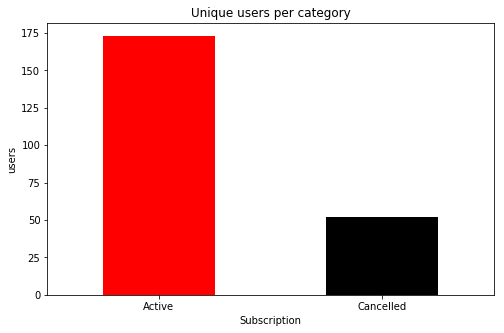

In [30]:
#generate a bar chart showing the frequency of unique users in different categories
def plot_frequency(subset, group, labels, x_title="Subscription", y_title="users"):
    freq_counts = df1.drop_duplicates(subset=subset).groupby(group)['userId'].count()
    fig, ax = plt.subplots(figsize=(8, 5))
    freq_counts.plot(kind='bar', ax=ax, color=['red', 'black'])
    ax.set_title('Unique users per category')
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_xticklabels(labels, rotation=0)
    plt.show()

plot_frequency(['userId'], ['churn'], ['Active', 'Cancelled'])

The status of "cancelled" accumulates 32% of users.

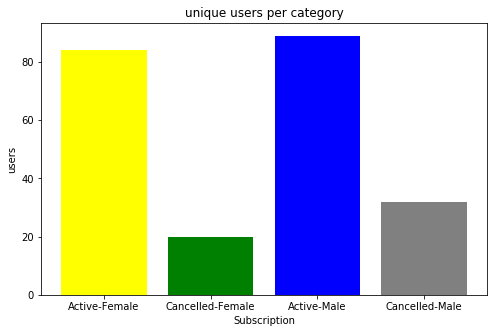

In [31]:
#view unique user count by gender and subscription status
import numpy as np
def plot_frequency(subset, group, labels, x_title="Subscription", y_title="users"):
    freq_counts = df1.drop_duplicates(subset=subset).groupby(group)['userId'].count()
    fig, ax = plt.subplots(figsize=(8, 5))
    x = np.arange(len(labels))
    
    colors=['yellow','green','blue','gray']
    ax.bar(x, freq_counts, color=colors)
    ax.set_title('unique users per category')
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=0)
    plt.show()

plot_frequency(['userId', 'gender'],
               ['gender', 'churn'],
               ['Active-Female', 'Cancelled-Female', 'Active-Male', 'Cancelled-Male'])

There is a direct relationship between the highest number of active subscriptions and the highest number of canceled subscriptions that, taking into account the gender, is male.

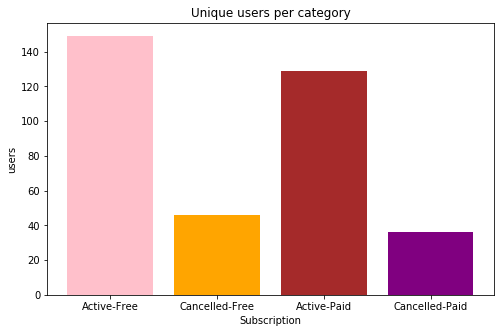

In [32]:
#shows the frequency of unique users in different categories
def plot_frequency(subset, group, labels, x_title="Subscription", y_title="users"):
    freq_counts = df1.drop_duplicates(subset=subset).groupby(group)['userId'].count()
    fig, ax = plt.subplots(figsize=(8, 5))
    x = np.arange(len(labels))
    
    colors=['pink','orange','brown','purple']
    ax.bar(x, freq_counts, color=colors)
    ax.set_title('Unique users per category')
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=0)
    plt.show()

plot_frequency(['userId', 'level'],
               ['level', 'churn'],
               ['Active-Free', 'Cancelled-Free', 'Active-Paid', 'Cancelled-Paid'])

85% of total active Sparkify users are paid subscriptions, 77% of total canceled users were paid subscriptions.

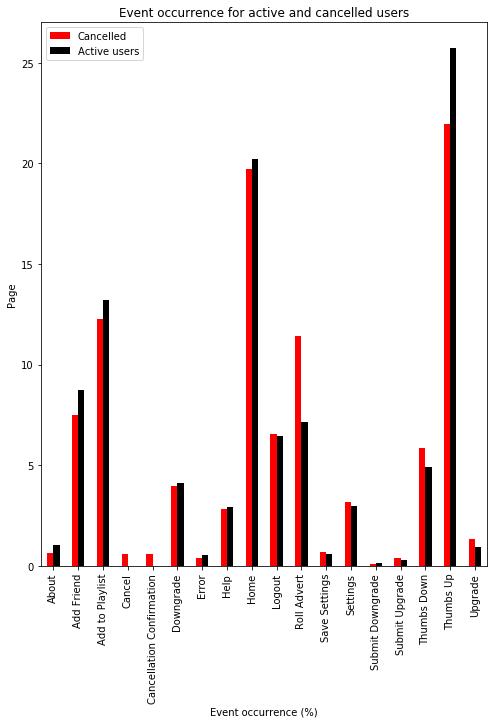

In [33]:
#The provided code performs an analysis of the event pages based on the cancellation status of the users. First, the percentage occurrence of events for canceled and active users on each page is calculated. A bar chart is then created showing the comparison of these percentages between the two groups of users. The graph provides a visualization of the difference in event distribution between canceled users and active users on different pages.
users_1 = df1[df1.churn == 1].groupby(['page'])['userId'].count().drop('NextSong')
users_1 = users_1 / users_1.sum() * 100

users_0 = df1[df1.churn == 0].groupby(['page'])['userId'].count().drop('NextSong')
users_0 = users_0 / users_0.sum() * 100

users_df = pd.DataFrame({'Cancelled': users_1, 'Active users': users_0})
fig, ax = plt.subplots(figsize=(8, 10))
users_df.plot(kind='bar', ax=ax, color=['red', 'black'])
ax.set_xlabel('Event occurrence (%)')
ax.set_ylabel('Page')
ax.set_title('Event occurrence for active and cancelled users')
plt.show()

The activity on the page: Add friend and Add to playlist are notable in relation to the use of Sparkify, the activity with the highest use of the page: Thumps up is for both active users and those who have cancelled.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [34]:
#perform an operation on the DataFrame 'df' to get a new DataFrame called 'churn_users'. This new DataFrame contains the 'userId' and 'churn' columns and is obtained by removing duplicate rows based on these two columns. Then, the content of the 'churn_users' DataFrame is displayed in the output. This allows us to see the unique values ​​of 'userId' along with their 'churn' status.

churn_users = df.drop_duplicates(['userId', 'churn']).select('userId', 'churn')
churn_users.show()

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



In [35]:
#The provided code defines a function called 'create_dummy_df' which creates a new DataFrame from another existing DataFrame. In this case, it is used to create a DataFrame named 'gender_df' containing the 'userId' and 'gender' columns. The function replaces the values ​​in the 'gender' column based on a given dictionary, converts the data type of the 'gender' column to an integer, and displays the schema and content of the resulting new DataFrame. In this case, 'M' values ​​are replaced with '1' and 'F' values ​​are replaced with '0'. This approach allows converting categorical values ​​into numerical variables for further analysis or modeling.
def create_supposed_df(col, dictionary):
   
    col_df = df.select('userId', col).dropDuplicates().replace(dictionary, subset=col)
    col_df = col_df.select('userId', col_df[col].cast('int'))
    col_df.printSchema()
    col_df.show()
    return col_df

gender_df = create_supposed_df('gender', {'M': '1', 'F': '0'})

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    72|     0|
|300023|     0|
|    39|     0|
|100010|     0|
|    40|     0|
|    94|     0|
|    35|     0|
|    75|     0|
|   116|     0|
|200001|     1|
|200020|     1|
|100008|     0|
|200015|     1|
|   100|     1|
|100006|     0|
|300005|     0|
|    25|     0|
+------+------+
only showing top 20 rows



In [36]:
#The function would use an existing DataFrame and replace the values ​​in the 'level' column based on a given dictionary. In this case, 'paid' values ​​would be replaced with '1' and 'free' values ​​would be replaced with '0'. Then the resulting DataFrame would display its schema and content. This approach allows you to convert the values ​​of the 'level' column into numeric variables for further analysis or modeling.
level_df = create_supposed_df('level', {'paid': '1', 'free': '0'})

root
 |-- userId: string (nullable = true)
 |-- level: integer (nullable = true)

+------+-----+
|userId|level|
+------+-----+
|100021|    0|
|200021|    0|
|200001|    0|
|     6|    0|
|300022|    1|
|   132|    0|
|   112|    0|
|    79|    0|
|200008|    0|
|    16|    1|
|200007|    1|
|300015|    0|
|    39|    0|
|300014|    1|
|    61|    0|
|    56|    1|
|300014|    0|
|   100|    1|
|300024|    1|
|300023|    1|
+------+-----+
only showing top 20 rows



In [37]:
#number of different artists present in the 'artist' column of the DataFrame 'dfp'
df1.artist.unique().shape[0]

17656

In [38]:
#The code performs some data processing to calculate the average length and standard deviation of the songs played by each user
from pyspark.sql import functions as sF
song_length = df.filter(df.page=='NextSong').select('userId', 'sessionId', 'length')
song_length = song_length.withColumn('hours', (song_length.length / 3600))
song_length = song_length.groupBy('userId', 'sessionId').sum('hours')
song_length = song_length.groupBy('userId').agg(
                        sF.avg('sum(hours)').alias('mean_hours'), 
                        sF.stddev('sum(hours)').alias('stdev_hours')).na.fill(0)
song_length.toPandas().head()

,userId,mean_hours,stdev_hours
0,100010,2.656385,1.594089
1,200002,4.352263,3.481087
2,125,0.580309,0.000000
3,51,14.535440,11.600663
4,124,10.042779,9.370878


In [39]:
#Perform data processing to obtain the distribution of the pages visited by each user in the form of normalized percentages. This is achieved by creating a new DataFrame 'user_page_distribution' containing the 'userId' columns and the pages columns, where each value represents the percentage of visits to that page per user
from functools import reduce

user_page_distribution = df.groupby('userId').pivot('page').count().na.fill(0)
user_page_distribution = user_page_distribution.drop(*['Cancel','Cancellation Confirmation'])
pages_cols = user_page_distribution.columns[1:]
new_df = user_page_distribution.withColumn('total', sum(user_page_distribution[col] for col in pages_cols))
for col in pages_cols:
    new_df = new_df.withColumn(f'norm_{col}', new_df[col] / new_df['total'] * 100.)
new_df = new_df.drop('total')
new_df = new_df.drop(*pages_cols)
oldColumns = new_df.columns
newColumns = ['userId'] + pages_cols
user_page_distribution = reduce(lambda new_df, idx: new_df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), new_df)
new_df=None

user_page_distribution.toPandas().head()

,userId,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,0.632911,0.843882,1.687764,1.054852,0.000000,0.421941,4.219409,1.054852,81.645570,1.476793,0.000000,0.632911,0.0,0.21097,1.265823,4.430380,0.421941
1,100010,0.262467,1.049869,1.837270,0.000000,0.000000,0.524934,2.887139,1.312336,72.178478,13.648294,0.000000,0.000000,0.0,0.00000,1.312336,4.461942,0.524934
2,125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,88.888889,11.111111,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000
3,51,0.081235,1.137287,2.112104,0.934200,0.040617,0.487409,3.046304,0.974817,85.743298,0.000000,0.040617,0.487409,0.0,0.00000,0.852965,4.061738,0.000000
4,124,0.145078,1.533679,2.445596,0.849741,0.124352,0.476684,3.647668,1.222798,84.538860,0.082902,0.124352,0.414508,0.0,0.00000,0.849741,3.544041,0.000000


In [40]:
#calculate the average and standard deviation of the number of songs played per session for each user

song_user_df = (
    df.filter(df.page == 'NextSong')
    .groupBy('userId', 'sessionId')
    .count()
    .groupBy('userId')
    .agg(avg('count').alias('mean_songs'), stddev('count').alias('stdev_songs'))
    .na.fill(0)
)

song_user_df.show()

+------+------------------+------------------+
|userId|        mean_songs|       stdev_songs|
+------+------------------+------------------+
|100010|39.285714285714285| 22.96166577663945|
|200002|              64.5|51.309843110264914|
|   125|               8.0|               0.0|
|    51|             211.1| 168.1483802413148|
|   124|145.67857142857142|137.40587446912284|
|     7|21.428571428571427|23.859709015109853|
|    54| 81.17142857142858|  98.4110484335042|
|    15|136.71428571428572| 88.69084470262945|
|   155|136.66666666666666| 96.74433661288224|
|100014|42.833333333333336|24.400136611639425|
|   132|             120.5|  119.663973971562|
|   154|              28.0|13.892443989449804|
|   101|             179.7|216.24320156301383|
|    11|           40.4375| 38.78826068112189|
|300017|59.540983606557376| 53.14056008063013|
|   138|             138.0|170.34838252408335|
|    29| 89.05882352941177| 125.9364777772414|
|    69|             125.0|116.83535423834688|
|100021|     

In [41]:
#calculates the number of unique artists listened to by each user
artists_user_fans = (
    df.select('userId', 'artist')
    .dropDuplicates()
    .groupBy('userId')
    .count()
    .withColumnRenamed('count', 'num_artists')
)

artists_user_fans.show()

+------+-----------+
|userId|num_artists|
+------+-----------+
|100010|        253|
|200002|        340|
|   125|          9|
|    51|       1386|
|   124|       2233|
|     7|        143|
|    15|       1303|
|    54|       1745|
|   155|        644|
|   132|       1300|
|   154|         79|
|100014|        234|
|   101|       1242|
|    11|        535|
|   138|       1333|
|300017|       2071|
|    29|       1805|
|    69|        866|
|100021|        208|
|    42|       2074|
+------+-----------+
only showing top 20 rows



In [42]:
#calculates the duration of each user session in hours from the recorded timestamps
from pyspark.sql.functions import col, expr

session_end = (
    df.groupBy('userId', 'sessionId')
    .agg(expr('max(ts)').alias('end'))
)

session_start = (
    df.groupBy('userId', 'sessionId')
    .agg(expr('min(ts)').alias('start'))
)

ticks_per_hour = 1000 * 60 * 60

session_df = (
    session_start.join(session_end, ['userId', 'sessionId'])
    .withColumn('session_hours', (col('end') - col('start')) / ticks_per_hour)
    .select('userId', 'sessionId', 'session_hours')
)

session_df.show()

+------+---------+--------------------+
|userId|sessionId|       session_hours|
+------+---------+--------------------+
|   101|      635|  55.000277777777775|
|   110|     1776|  1.3908333333333334|
|   120|      627|  15.855555555555556|
|   122|      691| 0.30833333333333335|
|   140|      798| 0.16027777777777777|
|   153|     1794|   4.196944444444444|
|    29|     1030|  0.7727777777777778|
|300011|       60|  1.7230555555555556|
|    35|     2270|  0.6547222222222222|
|    42|      433|  1.2455555555555555|
|     8|     1200|  0.6555555555555556|
|    92|      358|   4.288611111111111|
|    96|     1653|   9.323055555555555|
|    97|     2019|   4.828611111111111|
|100013|       13|   2.637777777777778|
|   123|     1901|  1.2116666666666667|
|   137|      136| 0.32305555555555554|
|   149|     1022|  3.6633333333333336|
|200023|       78|0.043055555555555555|
|    24|      620| 0.35805555555555557|
+------+---------+--------------------+
only showing top 20 rows



In [43]:
#calculates the mean and standard deviation of session durations per user
from pyspark.sql.functions import avg, stddev, col

session_user_df = (
    session_df.groupBy('userId')
    .agg(avg('session_hours').alias('mean_session_h'), stddev('session_hours').alias('stdev_session_h'))
    .na.fill(0)
)

session_user_df.show()

+------+-------------------+------------------+
|userId|     mean_session_h|   stdev_session_h|
+------+-------------------+------------------+
|100010|  2.574722222222223|1.5888758093219746|
|200002|               4.44| 3.615756029749058|
|   125|0.49277777777777776|               0.0|
|    51| 14.539277777777775|11.671992558014606|
|   124|  9.649904214559387| 9.380928117286047|
|     7| 1.4606746031746032|1.7396404190170895|
|    54|  5.371493993993996| 6.722524606551977|
|    15|  8.804722222222223| 6.433439835350866|
|   155|   9.14287037037037| 6.519267089541098|
|100014| 3.0802314814814817|1.7541325317050616|
|   132|  8.315850694444444| 8.396946451327924|
|   154| 1.8447222222222222|0.8584119435415696|
|   101| 13.626333333333331|16.632464583892272|
|    11| 2.6896180555555556| 2.757270987984882|
|300017| 3.8887345679012344|3.6192211259588243|
|   138|  9.403777777777778|11.696715229237652|
|    29|  6.095947712418298| 8.745464983754097|
|    69|  8.778086419753087|  8.27700901

In [44]:
#calculates the number of sessions for each user, eliminating duplicate sessions
from pyspark.sql.functions import count

num_sessions_user_df = (
    df.select('userId', 'sessionId')
    .dropDuplicates()
    .groupby('userId')
    .agg(count('*').alias('num_sessions'))
)

num_sessions_user_df.show()

+------+------------+
|userId|num_sessions|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
|    51|          10|
|   124|          29|
|     7|           7|
|    54|          37|
|    15|          15|
|   155|           6|
|100014|           6|
|   132|          16|
|   154|           3|
|   101|          10|
|    11|          16|
|300017|          63|
|   138|          15|
|    29|          34|
|    69|           9|
|100021|           5|
|    42|          47|
+------+------------+
only showing top 20 rows



In [45]:
#calculates the number of days since subscription for each user
from pyspark.sql.functions import expr

def days_since_subscription(df, col_name='days_on'):
    reg_ts = (
        df.select('userId', 'registration')
        .dropDuplicates()
        .withColumnRenamed('registration', 'start')
    )
    end_ts = (
        df.groupBy('userId')
        .max('ts')
        .withColumnRenamed('max(ts)', 'end')
    )
    reg_df = reg_ts.join(end_ts, 'userId')
    reg_df = reg_df.withColumn(col_name, expr('(end - start) / (1000 * 60 * 60 * 24)'))
    reg_df = reg_df.select('userId', col_name)
    return reg_df

reg_df = days_since_subscription(df, col_name='days_total_subscription')
reg_df.show()

+------+-----------------------+
|userId|days_total_subscription|
+------+-----------------------+
|100010|      55.64365740740741|
|200002|      70.07462962962963|
|   125|      71.31688657407408|
|   124|     131.55591435185184|
|    51|     19.455844907407407|
|     7|      72.77818287037037|
|    15|     56.513576388888886|
|    54|     110.75168981481481|
|   155|     23.556018518518517|
|100014|      85.08340277777778|
|   132|       66.8891087962963|
|   154|     23.872037037037035|
|   101|             53.9659375|
|    11|     124.47825231481481|
|   138|      66.62668981481481|
|300017|      74.35851851851852|
|100021|      64.73886574074074|
|    29|     60.104050925925925|
|    69|      71.42444444444445|
|   112|      87.46262731481481|
+------+-----------------------+
only showing top 20 rows



In [46]:
#filters the original DataFrame to get only the rows with 'paid' subscription level, then calculates the number of days since paid subscription for each user
from pyspark.sql.functions import expr

df_paid = df.filter(expr("level = 'paid'"))
paid_df = days_since_subscription(df_paid, col_name='days_paid_subscription')
paid_df.show()

+------+----------------------+
|userId|days_paid_subscription|
+------+----------------------+
|200002|     70.07462962962963|
|   124|    131.55591435185184|
|    51|    19.455844907407407|
|    15|    56.513576388888886|
|    54|    110.75168981481481|
|   155|    23.556018518518517|
|100014|     85.08340277777778|
|   132|      66.8891087962963|
|   101|            53.9659375|
|    11|    124.47825231481481|
|   138|     66.62668981481481|
|300017|     74.35851851851852|
|    29|    60.104050925925925|
|    69|     71.42444444444445|
|    42|     67.11364583333334|
|    73|     49.76208333333334|
|    87|    59.125856481481485|
|     3|     80.89527777777778|
|   113|    123.53140046296296|
|    30|     63.06664351851852|
+------+----------------------+
only showing top 20 rows



In [47]:
#The code filters and processes two different subsets of the original data frame df based on the level ("free" and "paid"). Then calculate the subscription duration in days for each user in each subset
df_free = df.filter(expr("level = 'free'"))
free_df = days_since_subscription(df_free, col_name='days_free_subscription')
free_df.show()

+------+----------------------+
|userId|days_free_subscription|
+------+----------------------+
|100010|     55.64365740740741|
|200002|     41.49415509259259|
|   125|     71.31688657407408|
|     7|     72.77818287037037|
|    54|     96.45179398148149|
|   155|               4.14625|
|   132|    16.472384259259258|
|   154|    23.872037037037035|
|   101|     39.77072916666667|
|    11|     113.7862037037037|
|   138|    27.158344907407407|
|100021|     64.73886574074074|
|    29|    23.483113425925925|
|    69|    24.491319444444443|
|   112|     87.46262731481481|
|    42|    12.798796296296297|
|    73|     28.26773148148148|
|    87|     58.49888888888889|
|200010|    38.142488425925926|
|    64|     49.15244212962963|
+------+----------------------+
only showing top 20 rows



Collect all

In [48]:
#both lists contain a collection of dataframes related to various user characteristics. The names in user_features_names provided a reference to identify each data frame in user_features.
user_features = [gender_df, song_length, 
                 user_page_distribution, song_user_df, artists_user_fans, 
                 session_user_df, num_sessions_user_df, reg_df]
user_features_names = ['gender_df', 'song_length', 
                       'user_page_distribution', 'song_user_df', 'artists_user_fans', 
                       'session_user_df', 'num_sessions_user_df', 'reg_df']

In [49]:
#performs the union of multiple dataframes of user characteristics with a base dataframe, generating a final dataframe with all the characteristics combined. Each feature dataframe is joined using the 'userId' column and the result is sorted by 'userId'

final_df = churn_users

def join_features(base, new):
    return base.join(new, 'userId', how='inner').dropDuplicates()

for feature, feature_name in zip(user_features, user_features_names):
    final_df = join_features(final_df, feature)

final_df = final_df.orderBy('userId', ascending=True)

In [50]:
#the code deletes a directory if it already exists and then saves the final_df dataframe in CSV format
import shutil
import os

directory_path = 'user_dataset.CSV'

if os.path.exists(directory_path):
    shutil.rmtree(directory_path)

final_df.write.save('user_dataset.CSV', format='csv', header=True)

In [51]:
#convert the Spark DataFrame to a Pandas DataFrame
final_df1 = final_df.toPandas()
final_df1.head()

,userId,churn,gender,mean_hours,stdev_hours,About,Add Friend,Add to Playlist,Downgrade,Error,...,Thumbs Down,Thumbs Up,Upgrade,mean_songs,stdev_songs,num_artists,mean_session_h,stdev_session_h,num_sessions,days_total_subscription
0,10,0,1,7.725295,8.985657,0.251572,1.509434,1.132075,0.880503,0.000000,...,0.503145,4.654088,0.000000,112.166667,133.324291,566,7.662454,8.991061,6,51.762650
1,100,0,1,5.497368,5.137933,0.373367,1.524580,1.897946,0.933416,0.093342,...,0.840075,4.604854,0.031114,78.882353,74.057621,1706,5.275317,5.133618,35,64.873773
2,100001,1,0,2.435677,1.055065,0.000000,1.081081,1.621622,0.000000,0.540541,...,1.081081,4.324324,1.081081,33.250000,16.839933,126,2.469306,1.051126,4,44.800220
3,100002,0,0,3.441661,5.918537,0.000000,0.458716,2.293578,0.917431,0.000000,...,0.000000,2.293578,0.000000,48.750000,84.428964,185,3.353056,5.901765,4,160.472072
4,100003,1,0,1.709225,2.265005,0.000000,0.000000,2.631579,0.000000,0.000000,...,0.000000,3.947368,0.000000,25.500000,33.234019,51,1.651944,2.260385,2,22.748113


In [52]:
final_df1.to_csv('user_dataset_definitive.CSV', index=False)

In [53]:
#loads the CSV file into a Spark DataFrame, converts it to a Pandas DataFrame
final_df = spark.read.csv('user_dataset.CSV', header = True)
final_1_df = final_df.toPandas()
final_1_df.head()

,userId,churn,gender,mean_hours,stdev_hours,About,Add Friend,Add to Playlist,Downgrade,Error,...,Thumbs Down,Thumbs Up,Upgrade,mean_songs,stdev_songs,num_artists,mean_session_h,stdev_session_h,num_sessions,days_total_subscription
0,30,0,1,3.5695262464285724,4.828511661476807,0.16901408450704225,1.4084507042253522,2.647887323943662,0.3380281690140845,0.056338028169014086,...,0.9577464788732395,3.492957746478873,0.7887323943661971,50.607142857142854,68.92579976333879,1019,3.0599045138888887,4.655638231407505,32,63.06664351851852
1,300001,1,0,7.08366019133987,6.033745302256485,0.04616805170821791,1.3850415512465373,3.1855955678670362,0.41551246537396125,0.13850415512465375,...,0.7848568790397045,6.832871652816251,0.09233610341643582,102.88235294117646,88.12908313444346,1202,6.367543859649123,6.150871757879998,19,188.3117824074074
2,91,0,1,19.746496319444457,23.04353070827294,0.16589250165892502,1.39349701393497,2.12342402123424,0.7299270072992701,0.09953550099535502,...,0.7962840079628402,4.11413404114134,0.033178500331785,286.6666666666667,337.84426885770904,1619,19.665,23.019357929090734,9,116.02526620370371
3,92,0,0,4.932186793551587,6.091381883859682,0.29045643153526973,1.5214384508990317,2.503457814661134,0.9405255878284924,0.04149377593360996,...,0.9958506224066389,4.0387275242047025,0.06915629322268327,70.77380952380952,86.9796197137792,2905,4.745203488372092,6.054084867345142,86,83.52885416666666
4,200008,0,0,7.609977063703702,7.294883458281476,0.44731610337972166,1.341948310139165,2.2365805168986084,1.1928429423459244,0.14910536779324055,...,2.584493041749503,3.3797216699801194,0.049701789264413515,111.26666666666667,107.38613016763829,1160,7.5379259259259275,7.284556907097743,15,115.18381944444444


In [54]:
#renames the columns of the final_df DataFrame, replacing whitespace with underscores and removing periods in the column names, and then displays the new column names
final_df = final_df.toDF(*(col.replace(' ', '_').replace('.', '') for col in final_df.columns))
print(final_df.columns)

['userId', 'churn', 'gender', 'mean_hours', 'stdev_hours', 'About', 'Add_Friend', 'Add_to_Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll_Advert', 'Save_Settings', 'Settings', 'Submit_Downgrade', 'Submit_Upgrade', 'Thumbs_Down', 'Thumbs_Up', 'Upgrade', 'mean_songs', 'stdev_songs', 'num_artists', 'mean_session_h', 'stdev_session_h', 'num_sessions', 'days_total_subscription']


In [55]:
#converts the 'userId' columns and the first 11 columns of the final_df DataFrame to the IntegerType data type, and the remaining columns (starting with column 12) are converted to the FloatType data type. This is achieved using Spark SQL's withColumn() and cast() function

from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, FloatType

final_df = final_df.withColumn('userId', col('userId').cast(IntegerType()))

for col_name in final_df.columns[1:12]:
    final_df = final_df.withColumn(col_name, col(col_name).cast(IntegerType()))

for col_name in final_df.columns[12:]:
    final_df = final_df.withColumn(col_name, col(col_name).cast(FloatType()))

In [56]:
#replace null values (NaN) with the value 0
final_df = final_df.fillna(0)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [57]:
#prepares the data for use in a machine learning model by assembling the features, scaling them, and dividing them into training and test sets, 70% of the data is assigned to the training set (train) and 30% of the data to the test set. A seed of 100 is used to guarantee the reproducibility of the division

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assembler = VectorAssembler(inputCols=final_df.columns[2:], outputCol='features')
assembled_data = assembler.transform(final_df)

scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
scaled_data = scaler.fit(assembled_data).transform(assembled_data)

ml_data = scaled_data.select(scaled_data.churn.alias('label'), scaled_data.scaled_features.alias('features'))

train, test = ml_data.randomSplit([0.70, 0.30], seed=100)

The Logistic Regression model

In [58]:
#performs fit of a machine learning model using cross validation and saves the best fitted model to a specified file

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from datetime import datetime

def model_fitting(data, model_type, param_grid, save_as, num_folds=3, random_seed=179):
    model_evaluator = CrossValidator(estimator=model_type, estimatorParamMaps=param_grid,
                                     evaluator=MulticlassClassificationEvaluator(),
                                     numFolds=num_folds, seed=random_seed)
    t_start = datetime.now()
    fitted_model = model_evaluator.fit(data)
    t_dif = datetime.now() - t_start
    t_start = datetime.now()
    try:
        fitted_model.bestModel.save(save_as)
    except:
        # Overwrite if exists
        fitted_model.bestModel.write().overwrite().save(save_as)
    t_dif = datetime.now() - t_start
    return fitted_model

In [59]:
#It is useful for obtaining and presenting the evaluation metrics of a model in an orderly manner, both for training data and for test data

def get_formated_metrics(selected_model, test_data):
  
    def get_model_metrics(selected_model, model_type='train'):
      
        if model_type == 'train':
            metrics = selected_model.bestModel.summary
        else:
            metrics = selected_model

        acc = metrics.accuracy
        general = np.array((metrics.weightedFMeasure(),
                            metrics.weightedPrecision, metrics.weightedRecall,
                            metrics.weightedTruePositiveRate, metrics.weightedFalsePositiveRate))
        general = general.reshape(1, general.shape[0])
        labels = ['General'] + [f'Churn={x}' for x in metrics.labels]
        labeled = np.array((metrics.fMeasureByLabel(),
                            metrics.precisionByLabel, metrics.recallByLabel,
                            metrics.truePositiveRateByLabel, metrics.falsePositiveRateByLabel))
        conc_results = np.concatenate((general.T, labeled), axis=1)
        metrics_names = ['F-Measure', 'Precision', 'Recall', 'True_+ve_Rate', 'False_+ve_Rate']
        df_res = pd.DataFrame(conc_results, columns=labels, index=metrics_names)
        return acc, df_res

    acc_train, train_res = get_model_metrics(selected_model)

    model_test = selected_model.bestModel.evaluate(test_data)

    acc_test, test_res = get_model_metrics(model_test, model_type='test')

    new_frame = pd.concat([train_res, test_res], axis=1, keys=[
        f'Training (Accuracy = {acc_train*100:4.2f}%)',
        f'Testing (Accuracy = {acc_test*100:4.2f}%)'])
    return new_frame

In [60]:
#configures and fits a logistic regression model using different combinations of hyperparameters defined in param_grid. Then, calculate and display the model's metrics using the test set
model = LogisticRegression()
param_grid = ParamGridBuilder() \
    .addGrid(model.regParam, [0.01, 0.1]) \
    .addGrid(model.elasticNetParam, [0.0, 0.5]) \
    .addGrid(model.aggregationDepth, [2, 5]) \
    .build()

m = model_fitting(train, model, param_grid, 'LogisticRegression.model')

# Model metrics
metrics = get_formated_metrics(m, test)
display(metrics)

Training (Accuracy = 82.35%)                      \
                                    General Churn=0.0 Churn=1.0   
F-Measure                          0.788186  0.895753  0.425532   
Precision                          0.825129  0.822695  0.833333   
Recall                             0.823529  0.983051  0.285714   
True_+ve_Rate                      0.823529  0.983051  0.285714   
False_+ve_Rate                     0.554764  0.714286  0.016949   

               Testing (Accuracy = 76.39%)                      
                                   General Churn=0.0 Churn=1.0  
F-Measure                         0.718160  0.859504  0.260870  
Precision                         0.719907  0.787879  0.500000  
Recall                            0.763889  0.945455  0.176471  
True_+ve_Rate                     0.763889  0.945455  0.176471  
False_+ve_Rate                    0.641964  0.823529  0.054545

The Decision Tree Classifier model

In [61]:
#allows classifier-specific evaluation metrics to be computed and presented in an ordered manner for training and test data sets

def get_classifier_metrics(trained_model, train_data, test_data):
    def get_specific_metrics(trained_model, data):
        res = trained_model.transform(data).select('label', 'prediction')
        true_pos = res.filter((res.prediction == 1) & (res.label == res.prediction)).count()
        true_neg = res.filter((res.prediction == 0) & (res.label == res.prediction)).count()
        false_pos = res.filter((res.prediction == 1) & (res.label != res.prediction)).count()
        false_neg = res.filter((res.prediction == 0) & (res.label != res.prediction)).count()
        accuracy = res.filter(res.label == res.prediction).count() / res.count()
        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        f1_score = 2 * precision * recall / (precision + recall)
        return accuracy, precision, recall, f1_score

    train_metrics = get_specific_metrics(trained_model, train_data)
    test_metrics = get_specific_metrics(trained_model, test_data)
    labels = ['Train', 'Test']
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F-Score']
    metrics_data = np.array((train_metrics, test_metrics))
    return pd.DataFrame(data=metrics_data.T, columns=labels, index=metrics_names)

In [62]:
#trains a decision tree classifier with different combinations of hyperparameters, saves the trained model, and then returns the classifier-specific evaluation metrics for the training and test sets

from pyspark.ml.classification import DecisionTreeClassifier
model = DecisionTreeClassifier()
param_grid = (ParamGridBuilder()
              .addGrid(model.maxDepth, [2, 4, 8])
              .addGrid(model.impurity, ['entropy', 'gini'])
              .build())

m = model_fitting(train, model, param_grid, 'DecisionTreeClassifier.model')

get_classifier_metrics(m, train, test)

,Train,Test
Accuracy,0.836601,0.763889
Precision,0.708333,0.500000
Recall,0.485714,0.235294
F-Score,0.576271,0.320000


The Gradient-Boosted Trees (GBTs) model

In [63]:
#trains a Gradient Boosted Trees (GBT) classifier with different combinations of hyperparameters, saves the trained model, and displays classifier-specific evaluation metrics for the training and test sets

model = GBTClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth, [2, 4, 8]) \
    .addGrid(model.maxBins, [6, 3]) \
    .addGrid(model.maxIter, [10, 3]) \
    .build()

m = model_fitting(train, model, param_grid, 'GradientBoostedTrees.model')

display(get_classifier_metrics(m, train, test))

,Train,Test
Accuracy,0.856209,0.805556
Precision,0.882353,0.714286
Recall,0.428571,0.294118
F-Score,0.576923,0.416667


Random Forest model

In [64]:
#finds the best combination of hyperparameters for the RandomForestClassifier classifier using the cross-validation technique with the default number of folds 

model = RandomForestClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth, [2, 4]) \
    .addGrid(model.impurity, ['entropy', 'gini']) \
    .addGrid(model.maxBins, [6, 3]) \
    .addGrid(model.numTrees, [10, 3]) \
    .addGrid(model.featureSubsetStrategy, ['sqrt', 'onethird']) \
    .build()

m = model_fitting(train, model, param_grid, 'RandomForestClassifier.model')

display(get_classifier_metrics(m, train, test))

,Train,Test
Accuracy,0.849673,0.791667
Precision,0.800000,0.666667
Recall,0.457143,0.235294
F-Score,0.581818,0.347826


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.